In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [ ]:
!jupyter nbconvert --to html lab6.ipynb

[NbConvertApp] Converting notebook lab6.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 535816 bytes to lab6.html


Кумирова Екатерина M34021

**Лабораторная работа №6**


Автоматизированная сборочная линия предприятия в среднем 1 раз в месяц выходит из строя и ремонтируется в среднем 3 дня. Кроме того, в среднем 2 раза в месяц она проходит техническое обслуживание, которое длится в среднем 1 день. В среднем в одном случае из трех при техническом обслуживании обнаруживается неполадка и линия ремонтируется. Необходимо определить сколько в среднем дней в месяц линия работает, обслуживается и ремонтируется.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In [ ]:
mpl.style.use(['ggplot'])

### **Схема конечного автомата СМО**

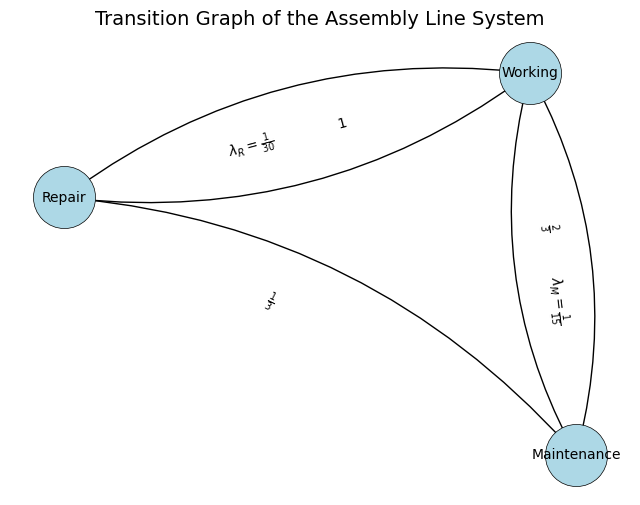

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx


G = nx.DiGraph()

states = {
    "W": "Working",
    "M": "Maintenance",
    "R": "Repair"
}
for state, label in states.items():
    G.add_node(state, label=label)

transitions = [
    ("W", "M", r"$\lambda_M = \frac{1}{15}$"),  # Переход из W в M
    ("W", "R", r"$\lambda_R = \frac{1}{30}$"),  # Переход из W в R
    ("M", "W", r"$\frac{2}{3}$"),              # Переход из M в W
    ("M", "R", r"$\frac{1}{3}$"),              # Переход из M в R
    ("R", "W", r"$1$"),                        # Переход из R в W
]

for src, dst, label in transitions:
    G.add_edge(src, dst, label=label)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Расположение узлов

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, labels={state: label for state, label in states.items()}, font_size=10)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="->", connectionstyle="arc3,rad=0.2")

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.6)

plt.title("Transition Graph of the Assembly Line System", fontsize=14)
plt.axis("off")
plt.show()

### **Характеристики переходов по заданным условиям**

#### **Состояния системы:**

*   **Working**

    Интенсивность перехода в состояние **On Maintenance (На ТО)** составляет:
      
      $$\lambda_{On Maintenance} = \frac{2}{30} = \frac{1}{15} \quad$$

    Интенсивность перехода в состояние **On Repair (В ремонте)** составляет:

      $$\lambda_{On Repair} = \frac{2}{30} = \frac{1}{30} \quad$$


*   **On Maintenance**

      Средняя длительность:
    
    $$\mu_M = 1 \quad $$

    По окончании обслуживания:
  
    \begin{aligned}
    &\text{С вероятностью } \frac{2}{3}  \Rightarrow \text{возвращаемся в Работу } (Working), \\
    &\text{С вероятностью } \frac{1}{3} \Rightarrow \text{отправляется в ремонт } (On Repair).
    \end{aligned}

*   **On Repair**

    Средняя длительность:
  
    $$\mu_R = \frac{1}{3} $$

    После ремонта всегда возвращается в состояние Working.


In [ ]:
Q = np.array([
    [-(2 / 30 + 1 / 30), 2 / 30, 1 / 30],
    [2 / 3, -1.0, 1 / 3],
    [1 / 3, 0.0, -1 / 3]
], dtype=float)

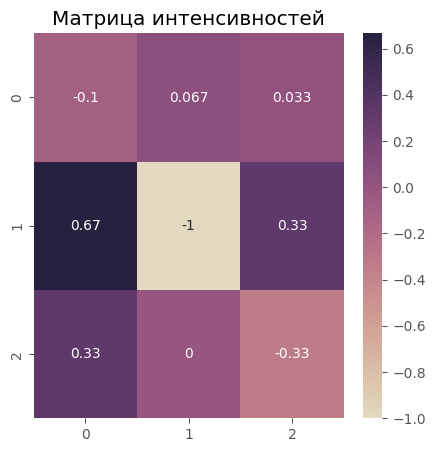

In [ ]:
plt.figure(figsize = (5, 5))
plt.title('Матрица интенсивностей')
sns.heatmap(Q, annot = True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.show()

### **Решение уравнений Колмогорова**

Ищем вектор $\mathbf{p} = (p_W, p_M, p_R)$, удовлетворяющий:
\begin{cases}
\mathbf{p} \cdot Q = 0, \\
p_W + p_M + p_R = 1.
\end{cases}

Где $p$ — строка-вероятность пребывания в каждом состоянии в стационарном режиме.



#### **Уравнения Колмогорова**

 Сумма предельных вероятностей равна 1:
   $$
   P_W + P_M + P_R = 1.
   $$

 Уравнения баланса для каждого состояния:
   - Для \(W\):
     $$
     \mu_M \cdot \frac{2}{3} \cdot P_M + \mu_R \cdot P_R = \lambda_W \cdot P_W.
     $$
     $$
     \frac{2}{3} P_M + \frac{1}{3} P_R = \frac{1}{10} P_W.
     $$

   - Для \(M\):
     $$
     \lambda_M \cdot P_W = \mu_M \cdot P_M.
     $$
     $$
     \frac{1}{15} P_W = P_M.
     $$

   - Для \(R\):
     $$
     \lambda_R \cdot P_W + \mu_M \cdot \frac{1}{3} \cdot P_M = \mu_R \cdot P_R.
     $$
     $$
     \frac{1}{30} P_W + \frac{1}{3} P_M = \frac{1}{3} P_R.
     $$


#### **Решение СЛАУ**

$$
\begin{cases}
P_W + P_M + P_R = 1, \\
\frac{2}{3} P_M + \frac{1}{3} P_R = \frac{1}{10} P_W, \\
P_M = \frac{1}{15} P_W, \\
\frac{1}{30} P_W + \frac{1}{3} P_M = \frac{1}{3} P_R.
\end{cases}
$$


 Подставляем $ P_M = \frac{1}{15} P_W $ в уравнение для $R$:
   $$
   \frac{1}{30} P_W + \frac{1}{3} \cdot \frac{1}{15} P_W = \frac{1}{3} P_R.
   $$
   $$
   \frac{1}{30} P_W + \frac{1}{45} P_W = \frac{1}{3} P_R.
   $$
   $$
   \frac{3}{90} P_W + \frac{2}{90} P_W = \frac{1}{3} P_R.
   $$
   $$
   \frac{5}{90} P_W = \frac{1}{3} P_R.
   $$
   $$
   P_R = \frac{5}{90} \cdot 3 \cdot P_W = \frac{1}{6} P_W.
   $$

 Подставляем $P_M = \frac{1}{15} P_W $ и $P_R = \frac{1}{6} P_W $ в уравнение суммы:
   $$
   P_W + \frac{1}{15} P_W + \frac{1}{6} P_W = 1.
   $$
   $$
   \frac{30}{30} P_W + \frac{2}{30} P_W + \frac{5}{30} P_W = 1.
   $$
   $$
   \frac{37}{30} P_W = 1.
   $$
   $$
   P_W = \frac{30}{37}.
   $$

 Найдём $P_M$ и $P_R$:
   $$
   P_M = \frac{1}{15} P_W = \frac{1}{15} \cdot \frac{30}{37} = \frac{2}{37}.
   $$
   $$
   P_R = \frac{1}{6} P_W = \frac{1}{6} \cdot \frac{30}{37} = \frac{5}{37}.
   $$


$$
P_W = \frac{30}{37} \approx 0.811, \quad
P_M = \frac{2}{37} \approx 0.054, \quad
P_R = \frac{5}{37} \approx 0.135.
$$

Система большую часть времени находится в состоянии $W(P_W \approx 81.1\%)$, что указывает на её высокую эффективность, т.к. на ремонт $(P_R \approx 13.5\%)$ и обслуживание $(P_M \approx 5.4\%)$ уходит относительно немного времени.
 Система успешно выполняет свои функции, обеспечивая долгий период работы с минимальными простоями.

In [ ]:
QT = Q.T
A = np.vstack((QT, np.array([1, 1, 1])))
b = np.array([0, 0, 0, 1])

p = np.linalg.lstsq(A, b, rcond=None)[0]
pW, pM, pR = p

print("Стационарные вероятности:")
print(f" pWorking = {pW},\n pMaintance = {pM},\n pRepair = {pR}")

Стационарные вероятности:
 pWorking = 0.8108108108108106,
 pMaintance = 0.054054054054053474,
 pRepair = 0.1351351351351357


In [ ]:
print(f"Проверка суммы:  {pW + pM + pR:.4f}")

Проверка суммы:  1.0000


### **Имитационная модель СМО**

In [ ]:
import numpy as np
import time
from datetime import datetime, timedelta

DAYS_TO_SECONDS = 24 * 3600

class AutomatedAssemblyLine:
    speed_factor: int = 24 * 3600 * 30

    def __init__(self) -> None:
        self._state_log: list[tuple[str, float]] = []
        self._current_state: str = "Working"

    def _generate_random_time(self, rate_per_day: float) -> float:
        random_days = np.random.exponential(1.0 / rate_per_day)
        real_seconds = random_days * DAYS_TO_SECONDS / self.speed_factor
        return real_seconds

    def _process_current_state(self) -> str:
        next_state: str = ""
        if self._current_state == "Working":
            failure_rate = 1 / 30
            maintenance_rate = 2 / 30

            time_to_failure = self._generate_random_time(failure_rate)
            time_to_maintenance = self._generate_random_time(maintenance_rate)

            if time_to_failure < time_to_maintenance:
                time.sleep(time_to_failure)
                next_state = "Under Repair"
            else:
                time.sleep(time_to_maintenance)
                next_state = "Under Maintenance"

        elif self._current_state == "Under Maintenance":
            maintenance_duration = self._generate_random_time(1)
            time.sleep(maintenance_duration)
            next_state = "Working" if np.random.rand() < 2 / 3 else "Under Repair"

        elif self._current_state == "Under Repair":
            repair_duration = self._generate_random_time(1 / 3)
            time.sleep(repair_duration)
            next_state = "Working"

        else:
            raise ValueError(f"Unknown state: {self._current_state}")

        return next_state

    def run_simulation(self, days_to_simulate: int = 30) -> None:
        end_time = datetime.now() + timedelta(days=days_to_simulate / self.speed_factor)
        while datetime.now() < end_time:
            old_state = self._current_state
            t0 = datetime.now()
            self._current_state = self._process_current_state()
            t1 = datetime.now()

            real_duration = (t1 - t0).total_seconds()
            simulated_days = real_duration * (self.speed_factor / DAYS_TO_SECONDS)

            self._state_log.append((old_state, simulated_days))

    def get_total_days_in_states(self) -> dict[str, float]:
        totals: dict[str, float] = {"Working": 0.0, "Under Maintenance": 0.0, "Under Repair": 0.0}
        for state, duration in self._state_log:
            totals[state] += duration
        return totals


### **Распределения предельных вероятностей, полученные имитационным моделированием**

In [ ]:
months_in_experiment = 12

def get_simulation_results(n_resamples: int):
    working_results = []
    maintenance_results = []
    repair_results = []

    for _ in range(n_resamples):
        model = AutomatedAssemblyLine()
        model.run_simulation(days_to_simulate=30 * months_in_experiment)
        simulation_results = model.get_total_days_in_states()
        sum_local_days = sum(simulation_results.values())

        total_sim_days = sum_local_days
        p_w = simulation_results["Working"] / total_sim_days
        p_m = simulation_results["Under Maintenance"] / total_sim_days
        p_r = simulation_results["Under Repair"] / total_sim_days

        working_results.append(p_w)
        maintenance_results.append(p_m)
        repair_results.append(p_r)

    return working_results, maintenance_results, repair_results

In [ ]:
def plot_kdeplot(ax, data, mean, expected_value, color, title, xlabel, ylabel=None):
    sns.kdeplot(data, color=color, fill=True, alpha=0.5, ax=ax)
    ax.axvline(expected_value, color='#c05d6d', linestyle=':', linewidth=1.5, label=f"Expected = {expected_value}")
    ax.axvline(mean, color='#aa83a6', linestyle=':', linewidth=1.5, label=f"Mean = {mean:.2f}")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.legend()

In [ ]:
def calculate_mean(results):
    return np.mean(results)

In [ ]:
def visualize_simulation_results(n_experiments: int = 100):
    working_results, maintenance_results, repair_results = get_simulation_results(n_experiments)

    mean_working = calculate_mean(working_results)
    mean_maintenance = calculate_mean(maintenance_results)
    mean_repair = calculate_mean(repair_results)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    plot_kdeplot(axes[0], working_results, mean_working, 0.81, '#cf9c9c', "Working", "Probability", "Frequency")
    plot_kdeplot(axes[1], maintenance_results, mean_maintenance, 0.05, "#aa83a6", "Under Maintenance", "Probability")
    plot_kdeplot(axes[2], repair_results, mean_repair, 0.14, "#d08692", "Under Repair", "Probability")

    fig.suptitle(f"Running {n_experiments} simulations", fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

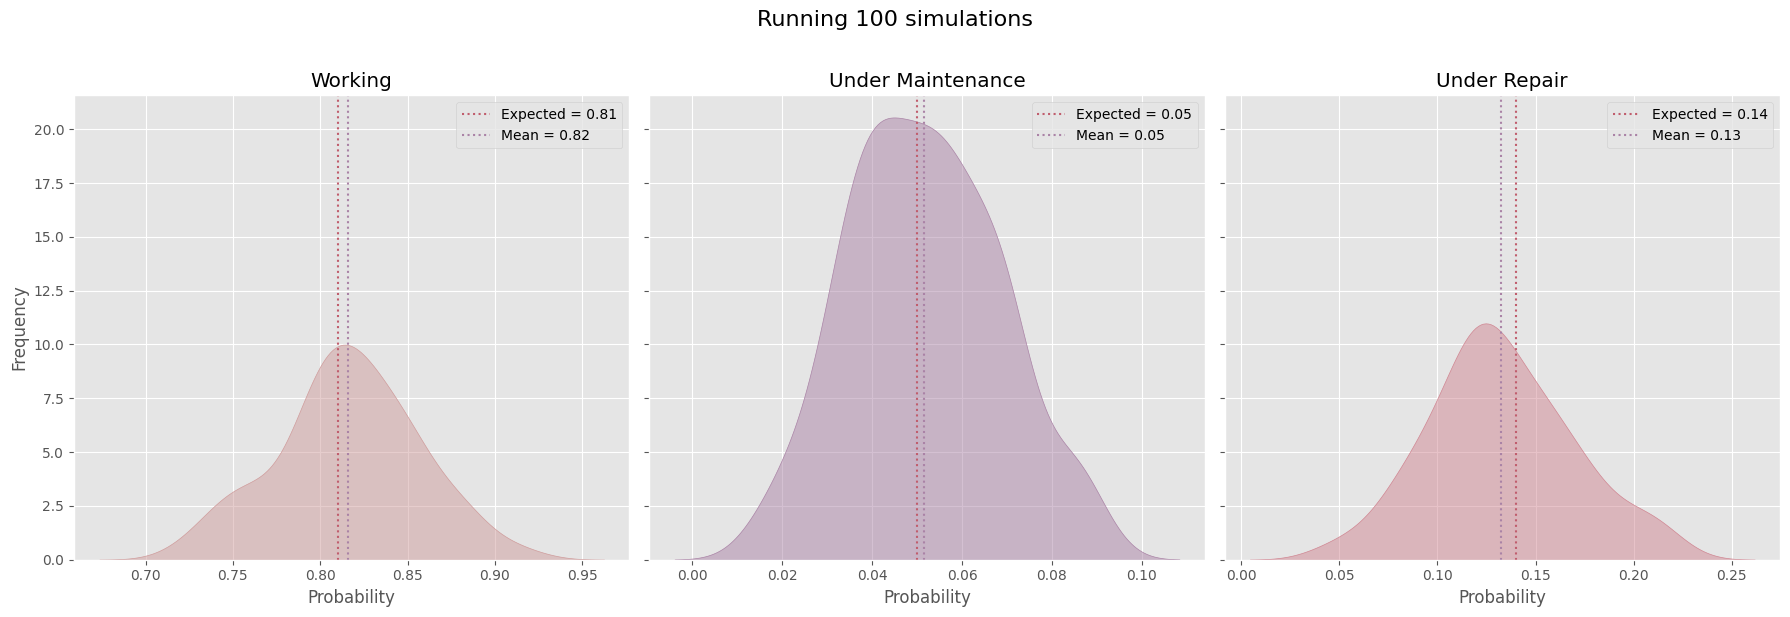

In [ ]:
for num_experiments in [100]:
    visualize_simulation_results(num_experiments)